We will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

**1. Load and normalize CIFAR10**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [4]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

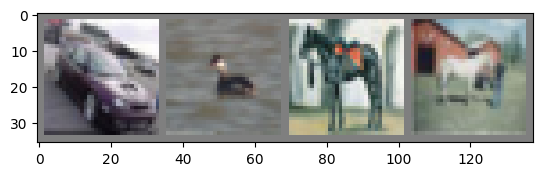

car   bird  horse horse


In [6]:
#Lets view some of those images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

detaiter = iter(trainloader)
images, labels = next(detaiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

**2. Define a Convolutional Neural Network**

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
net = Net()

Here ofcourse I see slight differences from the NN we defined in our breakdown notebook. We are taking 3 images as inputs instead of 1. Then the different operations/layers set in forward pass are more direct (i would say simpler here) and all being applied to that one variable `x`. 

**3. Define a Loss function and optimizer**

In [10]:
import torch.optim as optim

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

So here we have used Cross Entropy loss and SGD with `momentum` as the optimizer.

**4. Train the network**

And finally, argurably the fun part of this process. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished training')

[1,  2000] loss: 2.177
[1,  4000] loss: 1.810
[1,  6000] loss: 1.646
[1,  8000] loss: 1.564
[1, 10000] loss: 1.489
[1, 12000] loss: 1.438
[2,  2000] loss: 1.405
[2,  4000] loss: 1.345
[2,  6000] loss: 1.312
[2,  8000] loss: 1.319
[2, 10000] loss: 1.269
[2, 12000] loss: 1.251
Finished training


*Saving the model*

In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

**5. Test the network on the test data**

*One set of data*

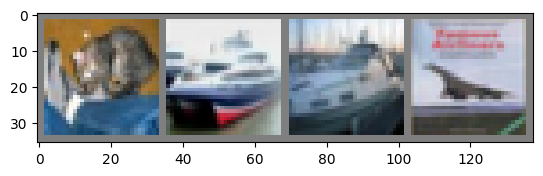

GroundTruth:  cat   ship  ship  plane


In [18]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [21]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [22]:
outputs = net(images)

In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


*Whole dataset*

In [24]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:

        images, labels = data
        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Our network is {100 * correct // total} % accurate on 10,000 test images')

Our network is 53 % accurate on 10,000 test images


*Prediction breakdown for specific classes*

In [25]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:

        images, labels = data
        outputs = net(images)

        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 50.7 %
Accuracy for class: car   is 57.9 %
Accuracy for class: bird  is 62.1 %
Accuracy for class: cat   is 22.6 %
Accuracy for class: deer  is 39.0 %
Accuracy for class: dog   is 43.2 %
Accuracy for class: frog  is 50.7 %
Accuracy for class: horse is 60.9 %
Accuracy for class: ship  is 87.0 %
Accuracy for class: truck is 58.4 %


In [26]:
del dataiter